Computations across multiple parameters to get metrics

In [45]:
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import math
import utils2
import pandas as pd
import libfmp.c6, libfmp.b
import warnings
from matplotlib.font_manager import FontProperties
import regex as re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.lines import Line2D
from scipy.interpolate import make_interp_spline
from scipy.interpolate import Akima1DInterpolator
from itertools import groupby
import seaborn as sns

from pydub import AudioSegment, silence
from pydub.playback import play
import soundfile as sf
from praatio import tgio
import copy

import ipywidgets as widgets
import IPython.display as ipd
from IPython.display import display, clear_output

import expressiveness_measure_new

#GUI
import sys
import numpy as np
import librosa
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
from PyQt5.QtWidgets import QApplication, QMainWindow, QWidget, QVBoxLayout, QHBoxLayout, QSlider, QPushButton
from PyQt5.QtCore import Qt, QTimer
from matplotlib.font_manager import FontProperties
import pyaudio
import threading
import pyaudio
import chardet


# Ignore all warnings
warnings.filterwarnings("ignore")

In [46]:
folder = "bhimpalasi_ja_jare"
artists = ["ABD", "AC", "AK", "DG", "IN", "KS", "MB", "NG", "PB", "PT", "PTJ", "RK", "RV", "SA", "SZ"]
syl_list = ["जा1", "जा2", "रे", "अ", "प", "ने", "मं", "दि1", "र", "वा"]
id_list = ["C1L1B7", "C1L2B9", "C1L2B11", "C1L2B13", "C1L2B14", "C1L2B15", "C2L1B1", "C2L1B3", "C2L1B4", "C2L1B5"]
hindi_font =FontProperties(fname=r"C:\Windows\Fonts\utsaah.ttf", size=20)

In [47]:
# folder = "yaman_yeri_aali"
# artists = ["ABD", "AC", "IN", "JV", "KA", "KA2", "KS", "MB", "RH", "SA", "SHS", "SS", "SZ"]
# syl_list = ["स", "खी", "ए", "री1", "आ", "ली", "पि1", "या1", "बि", "न1"]
# id_list = ["C2L1B7", "C2L1B8", "C1L2B9", "C1L2B11", "C1L2B13", "C1L2B15", "C2L1B1", "C2L1B2", "C2L1B3", "C2L1B4"]
# hindi_font =FontProperties(fname=r"C:\Windows\Fonts\utsaah.ttf", size=20)

In [48]:
ja_jare_eng_dict = {"जा1": "Jaa1", "जा2": "Jaa2", "रे": "Re", "अ": "A", "प": "Pa", "ने": "Ne", "मं": "Man", "दि1": "di1", "र": "Ra", "वा": "Waa", 
                    "सु": "Su", "न1": "Na1", "पा": "Paa", "वे": "We", "गी": "Gii", "सा": "Saa", "स": "Sa", "न2": "Na2", "न3": "Na3", "दि2": "di2", "या": "Yaa", 
                    "न4": "Na4", "हो": "Ho", "दा": "daa", "रं": "Ran", "ग": "Ga", "तु": "tu", "म": "Ma", "को": "Ko", "चा": "Chaa", "ह": "Ha", "त": "ta", "हैं": "Hain",
                    "क्या": "Kyaa", "छ": "Chha", "न5": "Na5", "दि3": "di3", "s": "-" }

yeri_aali_eng_dict = {"अ": "A", "ए": "Ye", "री1": "Rii1", "आ": "Aa", "ली": "Lii", "पि1": "Pi1", "या1": "Yaa1", "बि": "Bi", "न1": "Na1","पि": "Pi", "या": "Yaa", "न": "Na", "री": "Rii",
                      "स": "Sa", "खी": "Khi", "क": "Ka", "ल": "La", "ना": "Naa", "र": "Ra", "त": "ta", "मो": "Mo", "हे": "He", "घ": "Gha", "प": "Pa", "जि": "Ji", "दी": "dii",
                      "ज": "Ja", "ब": "Ba", "से": "Se", "दे": "de", "श": "Sha", "ग": "Ga", "व": "Wa", "की": "Kii", "नो": "No",
                      "ति": "ti", "याँ": "Yaan", "ट": "Ta", "ता": "taa", "रे": "Re", "गि": "Gi" }

In [49]:
def metrics(observations_per_id):
    syllable_count = []
    syllables_list = []
    avg_dev_frn = []
    avg_dev = []
    avg_matra_durn = []
    frn_dev_list = []
    taal_marks = []
    id_list = []
    for id in observations_per_id: #to get complete bandish plot, replace observations_per_id with bandish_order
        lines = observations_per_id[id]
        id_list.append(id)
        syllables_list.append(lines[0][0][1])
        syllable_count.append(len(lines))
        taal_marks.append(lines[0][1][1])
        sam_dev_frn = 0
        sam_dev = 0
        sam_matra = 0
        frn_devs = []
        for i in range(len(lines)):
            sam_dev_frn+=lines[i][0][3]
            sam_dev+=lines[i][0][2]
            sam_matra+=lines[i][1][4]
            frn_devs.append(lines[i][0][3])
        frn_dev_list.append(frn_devs)
        avg_dev_frn.append(sam_dev_frn/len(lines))
        avg_dev.append(sam_dev/len(lines))
        avg_matra_durn.append(sam_matra/len(lines))
    return syllable_count, syllables_list, avg_dev_frn, avg_dev, avg_matra_durn, frn_dev_list, taal_marks, id_list

In [ ]:
base_folder = "D:/Desktop/MIR/All_audio_files_16kHz"

def get_song_artist_mapping(root_folder):
    song_artist_dict = {} 
    for song_folder in os.listdir(root_folder):
        song_path = os.path.join(root_folder, song_folder)
        if os.path.isdir(song_path):
            # Collect artist folders inside each song folder
            artists = [artist for artist in os.listdir(song_path) if os.path.isdir(os.path.join(song_path, artist))]
            song_artist_dict[song_folder] = artists
    
    return song_artist_dict

options = get_song_artist_mapping(base_folder)


folder_dropdown = widgets.Dropdown(options=options.keys(), description="Folder:")
artist_dropdown = widgets.Dropdown(description="Artist:")
fetch_button = widgets.Button(description="Get Files")
output = widgets.Output()

files = []  # Declare files variable outside
folder_artist = []

def update_artist_dropdown(change):
    artist_dropdown.options = options[change['new']]

folder_dropdown.observe(update_artist_dropdown, names='value')

def get_file_paths(b):
    global files  # Refer to the global files variable
    with output:
        clear_output()
        folder, artist = folder_dropdown.value, artist_dropdown.value
        folder_artist.append(folder)
        folder_artist.append(artist)
        artist_folder = os.path.join(base_folder, folder, artist)
        prefix = f"{'ja_jare' if 'ja_jare' in folder else 'yeri_aali'}_{artist}"
        files = [os.path.join(artist_folder, f).replace("\\", "/") for f in os.listdir(artist_folder) if f.startswith(prefix)]
        print(f"Files in {folder}/{artist}:\n" + "\n".join(files))


fetch_button.on_click(get_file_paths)


display(folder_dropdown, artist_dropdown, fetch_button, output)
update_artist_dropdown({'new': folder_dropdown.value})  # Initialize dropdown


Dropdown(description='Folder:', options=('ahir_bhairav_albela_sajan', 'bhimpalasi_ja_jare', 'khamaj_koyaliya_k…

Dropdown(description='Artist:', options=(), value=None)

Button(description='Get Files', style=ButtonStyle())

Output()

In [51]:
artists_yeri_aali = ["ABD", "AC", "IN", "JV", "KA", "KA2", "KS", "MB", "RH", "SA", "SHS", "SS", "SZ"]
len(artists_yeri_aali)

13

In [30]:
line_count_yeri_aali = {}
MPM = {}
for artist in artists_yeri_aali:
    files = utils2.get_file_paths(base_folder, folder, artist)
    file_name = f"{'_'.join(folder.split('_')[1:])}_{artist}"
    # print(file_name, folder, artist)
    for i in files:
        name = i.split("/")[-1]
        if name == file_name+"_trimmed.wav": audio_file = i
        if name == file_name+"_segments.TextGrid": segments_tg = i
        if name == file_name+"_segments.txt": segments_txt = i
        if name == file_name+"_line_labels.txt": line_labels = i
        if name == file_name+"_labels.TextGrid" or name == file_name+"_syllables_corrected.TextGrid": labels_tg = i
        if name == file_name+"_raw_syllables.TextGrid": raw_labels_tg = i
        if name == file_name+"_trimmed_gaudiolab_other.wav": audio_ss_other = i
        if name == file_name+"_trimmed_gaudiolab_vocal.wav": audio_ss_vocal = i
        if name == file_name+"_tabla.TextGrid": tabla_tg = i
        if name == file_name+"_crepe_f0.pkl": f0_crepe_pkl = i
    tg_path = labels_tg
    manual_onsets = np.array(utils2.textgrid_to_onsets(tg_path, tier_number = 0)[0]) 
    manual_onsets = np.round(manual_onsets, 2) 
    manual_labels = list(np.array(utils2.textgrid_to_onsets(tg_path, tier_number = 0)[1]))
    line_count_yeri_aali[artist] = {"L1": int((manual_labels.count("आ")+manual_labels.count("बि"))/2), 
                          "L2": int((sum(1 for x, y in zip(manual_labels, manual_labels[1:]) if x == "क" and y == 'ल') + (manual_labels.count("घ")))/2),
                          "L3": int((manual_labels.count("ज")+manual_labels.count("ब")+manual_labels.count("ग"))/3),
                          "L4": int((manual_labels.count("ति")+manual_labels.count("ता"))/2),}
    # print(sum(1 for x, y in zip(manual_labels, manual_labels[1:]) if x == "क" and y == 'ल'))
    # print("wfdcsd",(manual_labels.count("घ")))
    tg_path2 = tabla_tg
    print(tg_path2)
    manual_tabla_onsets = np.array(utils2.textgrid_to_onsets(tg_path2)[0]) 
    manual_tabla_labels = np.array(utils2.textgrid_to_onsets(tg_path2)[1]) 
    manual_tabla_onsets = np.round(manual_tabla_onsets, 2) # to be according to the hop size 0.01s resolution
    inter_sam_interval = []
    for i in range(0, len(manual_tabla_onsets)-2, 2):
        inter_sam_interval.append(manual_tabla_onsets[i+2]-manual_tabla_onsets[i])
        
    inter_sam_interval = np.array(inter_sam_interval)

    mean_sam_interval = np.mean(inter_sam_interval)
    one_matra_interval = mean_sam_interval/16
    mpm = 1/(one_matra_interval/60)
    MPM[artist] = mpm

# line_count_yeri_aali
MPM
    
    

D:/Desktop/MIR/All_audio_files_16kHz/bhimpalasi_ja_jare/ABD/ja_jare_ABD_tabla.TextGrid
D:/Desktop/MIR/All_audio_files_16kHz/bhimpalasi_ja_jare/AC/ja_jare_AC_tabla.TextGrid
D:/Desktop/MIR/All_audio_files_16kHz/bhimpalasi_ja_jare/IN/ja_jare_IN_tabla.TextGrid
Error: The folder 'D:/Desktop/MIR/All_audio_files_16kHz\bhimpalasi_ja_jare\JV' does not exist.
D:/Desktop/MIR/All_audio_files_16kHz/bhimpalasi_ja_jare/IN/ja_jare_IN_tabla.TextGrid
Error: The folder 'D:/Desktop/MIR/All_audio_files_16kHz\bhimpalasi_ja_jare\KA' does not exist.
D:/Desktop/MIR/All_audio_files_16kHz/bhimpalasi_ja_jare/IN/ja_jare_IN_tabla.TextGrid
Error: The folder 'D:/Desktop/MIR/All_audio_files_16kHz\bhimpalasi_ja_jare\KA2' does not exist.
D:/Desktop/MIR/All_audio_files_16kHz/bhimpalasi_ja_jare/IN/ja_jare_IN_tabla.TextGrid
D:/Desktop/MIR/All_audio_files_16kHz/bhimpalasi_ja_jare/KS/ja_jare_KS_tabla.TextGrid
D:/Desktop/MIR/All_audio_files_16kHz/bhimpalasi_ja_jare/MB/ja_jare_MB_tabla.TextGrid
Error: The folder 'D:/Desktop/MI

{'ABD': 163.29175441438522,
 'AC': 161.34453781512605,
 'IN': 149.93610677268208,
 'JV': 149.93610677268208,
 'KA': 149.93610677268208,
 'KA2': 149.93610677268208,
 'KS': 184.43804034582132,
 'MB': 170.1475378424986,
 'RH': 170.1475378424986,
 'SA': 197.23643395238287,
 'SHS': 197.23643395238287,
 'SS': 197.23643395238287,
 'SZ': 138.00814631419217}

In [31]:
def metrics3(observations_per_id, alotted_beats):
    # label_map_no_NA
    for i in observations_per_id:          # for making the internal id of each syllable same as its key id
        lines = observations_per_id[i]
        for line in lines:
            line[1][3] = i

    label_map_no_NA = [line for lines in observations_per_id.values() for line in lines]
    # sorted_label_map
    sorted_label_map = sorted(label_map_no_NA, key=lambda x: x[0][0])
    # print(sorted_label_map)

    for i in range(len(sorted_label_map)):
        line = sorted_label_map[i]
        if i!=len(sorted_label_map)-1:
            this_time = sorted_label_map[i][0][0]
            next_time = sorted_label_map[i+1][0][0]
            sorted_label_map[i][0].insert(1, round(((next_time-this_time)/line[1][4]), 2))
        else:
            sorted_label_map[i][0].insert(1, alotted_beats[sorted_label_map[i][1][3]])

    observations_per_id1 = {}
    

    for id in list(observations_per_id.keys()):
        for line in sorted_label_map:
            if line[1][3] == id:
                # print(line[1][3]) if id == "C1L1B7" else None
                if id in observations_per_id1:
                    observations_per_id1[id].append(line)
                else:
                    observations_per_id1[id] = [line]
    adj_dist_list = []
    
    for i in observations_per_id1:
        lines = observations_per_id1[i]
        adj_dist = [lines[j][0][1] for j in range(len(lines))]
        adj_dist_list.append(adj_dist)
    avg_adj_dist = [np.mean(i) for i in adj_dist_list]
    return adj_dist_list, avg_adj_dist

In [32]:
def merge_by_syllable_first_key(og_data, id_list, syl_list):
    data = copy.deepcopy(og_data)

    syl_lab_dict = dict(zip(syl_list, id_list))
    merged_dict = {key: [] for key in id_list}

    label_map_no_NA = [line for lines in data.values() for line in lines]
    # sorted_label_map
    sorted_label_map = sorted(label_map_no_NA, key=lambda x: x[0][0])
    for line in sorted_label_map:
        syllable = line[0][1]
        print(syllable)
        if syllable in syl_lab_dict:
            id = syl_lab_dict[syllable]
            merged_dict[id].append(line)

    return merged_dict

# observations_per_id2 = merge_by_syllable_first_key(observations_per_id, id_list, syl_list) 
    

In [37]:
observn_per_idss = {}
syllable_devn_devns = {}
syllable_devns_means = {}
syllable_durn_devns = {}
syllable_durn_means = {}
mpm_dict = {}
man_onsets = {}
matched_onsets = {}
line_count = {}


for artist in artists:
    observations_per_id, manual_onsets_plot, manual_labels_plot, num_manual_onsets, sample_duration, split_onsets, split_onsets_labels, manual_tabla_onsets, manual_tabla_labels, vibhag_labels_list, mean_sam_interval, one_matra_interval, mpm, alotted_beats = expressiveness_measure_new.expressive_timing(folder, artist, prom=0.12, inter_onset_threshold=40, manual=True)
    observations_per_id = merge_by_syllable_first_key(observations_per_id, id_list, syl_list)
    syllable_count, syllables_list, avg_dev_frn, avg_dev, avg_matra_durn, frn_dev_list, taal_marks, id_list_full = metrics(observations_per_id)

    frn_dev_list_flat = np.array([i for item in frn_dev_list for i in item])

    Q3 = np.percentile(frn_dev_list_flat, 90)
    Q1 = np.percentile(frn_dev_list_flat, 10)
    IQR = Q3 - Q1
    lower_bound = Q1 - 0.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    frn_dev_list_no_outlier = []
    for dev_list in frn_dev_list:
        dev_list = np.array(dev_list)
        dev_list = dev_list[(dev_list >= lower_bound) & (dev_list <= upper_bound)]
        frn_dev_list_no_outlier.append(dev_list)

    devns_of_devns = [np.std(np.array(i)) for i in frn_dev_list_no_outlier]

    adj_dist_list, avg_adj_dist = metrics3(observations_per_id, alotted_beats)
    adj_dist_list_flat = np.array([i for item in adj_dist_list for i in item])

    Q3 = np.percentile(adj_dist_list_flat, 90)
    Q1 = np.percentile(adj_dist_list_flat, 10)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    adj_dist_list_no_outlier = []

    for dev_list in adj_dist_list:
        dev_list = np.array(dev_list)
        dev_list = dev_list[(dev_list >= lower_bound) & (dev_list <= upper_bound)]
        adj_dist_list_no_outlier.append(dev_list)
    
    devns_of_durns = [np.std(np.array(i)) for i in adj_dist_list_no_outlier]

    observn_per_idss[artist] = observations_per_id
    syllable_devn_devns[artist] = devns_of_devns
    syllable_devns_means[artist] = avg_dev_frn
    syllable_durn_devns[artist] = devns_of_durns
    syllable_durn_means[artist] = avg_adj_dist
    mpm_dict[artist] = mpm
    man_onsets[artist] = len(manual_onsets_plot)
    j = 0
    for i in observations_per_id:
        j+=len(observations_per_id[i])
    matched_onsets[artist] = j
    if folder=="yaman_yeri_aali":
        line_count[artist] = {"L1": int((manual_labels_plot.count("आ")+manual_labels_plot.count("पि1"))/2), 
                          "L2": int((sum(1 for x, y in zip(manual_labels_plot, manual_labels_plot[1:]) if x == "क" and y == 'ल') + (manual_labels_plot.count("घ")))/2),
                          "L3": int((manual_labels_plot.count("ज")+manual_labels_plot.count("ब")+manual_labels_plot.count("ग"))/3),
                          "L4": int((manual_labels_plot.count("ति")+manual_labels_plot.count("ता"))/2),}
    elif folder == "bhimpalasi_ja_jare":
        line_count[artist] = {"L1": int((manual_labels_plot.count("मं")+manual_labels_plot.count("दि1"))/2), 
                            "L2": int((manual_labels_plot.count("पा")+manual_labels_plot.count("न2")+manual_labels_plot.count("वे"))/3),
                            "L3": int((manual_labels_plot.count("रं")+manual_labels_plot.count("चा"))/2),
                            "L4": int((manual_labels_plot.count("क्या")+manual_labels_plot.count("ग"))/2),}
        

    
    

ja_jare_ABD
duration of one taal cycle:  5.88 s
duration of one matra:  0.37 s
mpm:  163.29
standard deviation of the duration of taal cycles  0.17 s
जा2
रे
अ
प
ने
मं
दि1
र
वा
जा1
जा2
रे
अ
प
ने
मं
दि1
र
वा
जा1
जा2
रे
अ
प
ने
मं
दि1
र
वा
जा1
जा2
रे
अ
प
ने
मं
दि1
र
वा
जा1
जा2
रे
अ
प
ने
मं
दि1
र
वा
जा1
जा2
रे
अ
प
ने
मं
दि1
र
वा
जा1
जा2
रे
अ
प
ने
मं
दि1
र
वा
जा1
जा2
रे
अ
प
ने
मं
दि1
र
वा
जा1
मं
दि1
र
वा
सु
न1
पा
वे
गी
सा
स
न2
न3
दि2
या
जा1
जा2
रे
अ
प
ने
मं
दि1
र
वा
सु
न1
पा
वे
गी
सा
स
न2
न3
दि2
या
जा1
जा2
रे
अ
प
ने
मं
दि1
र
वा
जा1
जा2
रे
सु
न4
हो
स
दा
रं
ग
तु
म
को
चा
ह
त
हैं
सु
न4
हो
स
दा
रं
ग
सु
न4
हो
स
दा
रं
ग
सु
न4
हो
स
दा
रं
ग
तु
म
को
चा
ह
त
हैं
सु
न4
हो
स
दा
रं
ग
तु
म
को
चा
ह
त
हैं
क्या
तु
म
ह
म
को
छ
ग
न5
दि3
या
क्या
तु
म
ह
म
को
छ
ग
न5
दि3
या
जा1
जा2
रे
अ
प
ने
ja_jare_AC
duration of one taal cycle:  5.95 s
duration of one matra:  0.37 s
mpm:  161.34
standard deviation of the duration of taal cycles  0.16 s
अ
प
ने
मं
दि1
र
वा
जा1
मं
दि1
र
वा
जा1
जा2
रे
अ
प
ने
मं
दि1
र
वा
जा1
जा2
रे
अ
प


In [38]:
line_count

{'ABD': {'L1': 12, 'L2': 2, 'L3': 4, 'L4': 4},
 'AC': {'L1': 9, 'L2': 4, 'L3': 2, 'L4': 3},
 'AK': {'L1': 5, 'L2': 2, 'L3': 2, 'L4': 2},
 'DG': {'L1': 17, 'L2': 4, 'L3': 4, 'L4': 4},
 'IN': {'L1': 6, 'L2': 1, 'L3': 2, 'L4': 2},
 'KS': {'L1': 9, 'L2': 2, 'L3': 2, 'L4': 3},
 'MB': {'L1': 6, 'L2': 2, 'L3': 3, 'L4': 3},
 'NG': {'L1': 8, 'L2': 2, 'L3': 4, 'L4': 4},
 'PB': {'L1': 34, 'L2': 8, 'L3': 4, 'L4': 3},
 'PT': {'L1': 8, 'L2': 1, 'L3': 2, 'L4': 2},
 'PTJ': {'L1': 12, 'L2': 2, 'L3': 3, 'L4': 2},
 'RK': {'L1': 7, 'L2': 1, 'L3': 2, 'L4': 2},
 'RV': {'L1': 16, 'L2': 2, 'L3': 4, 'L4': 3},
 'SA': {'L1': 10, 'L2': 2, 'L3': 7, 'L4': 7},
 'SZ': {'L1': 8, 'L2': 4, 'L3': 2, 'L4': 3}}

observn_per_idss 
syllable_devn_devns 
syllable_devns_means 
syllable_durn_devns 
syllable_durn_means 
mpm_dict 
man_onsets 
matched_onsets 
line_count 

full matrix for std dev of frnal dev for all syllables for all artists

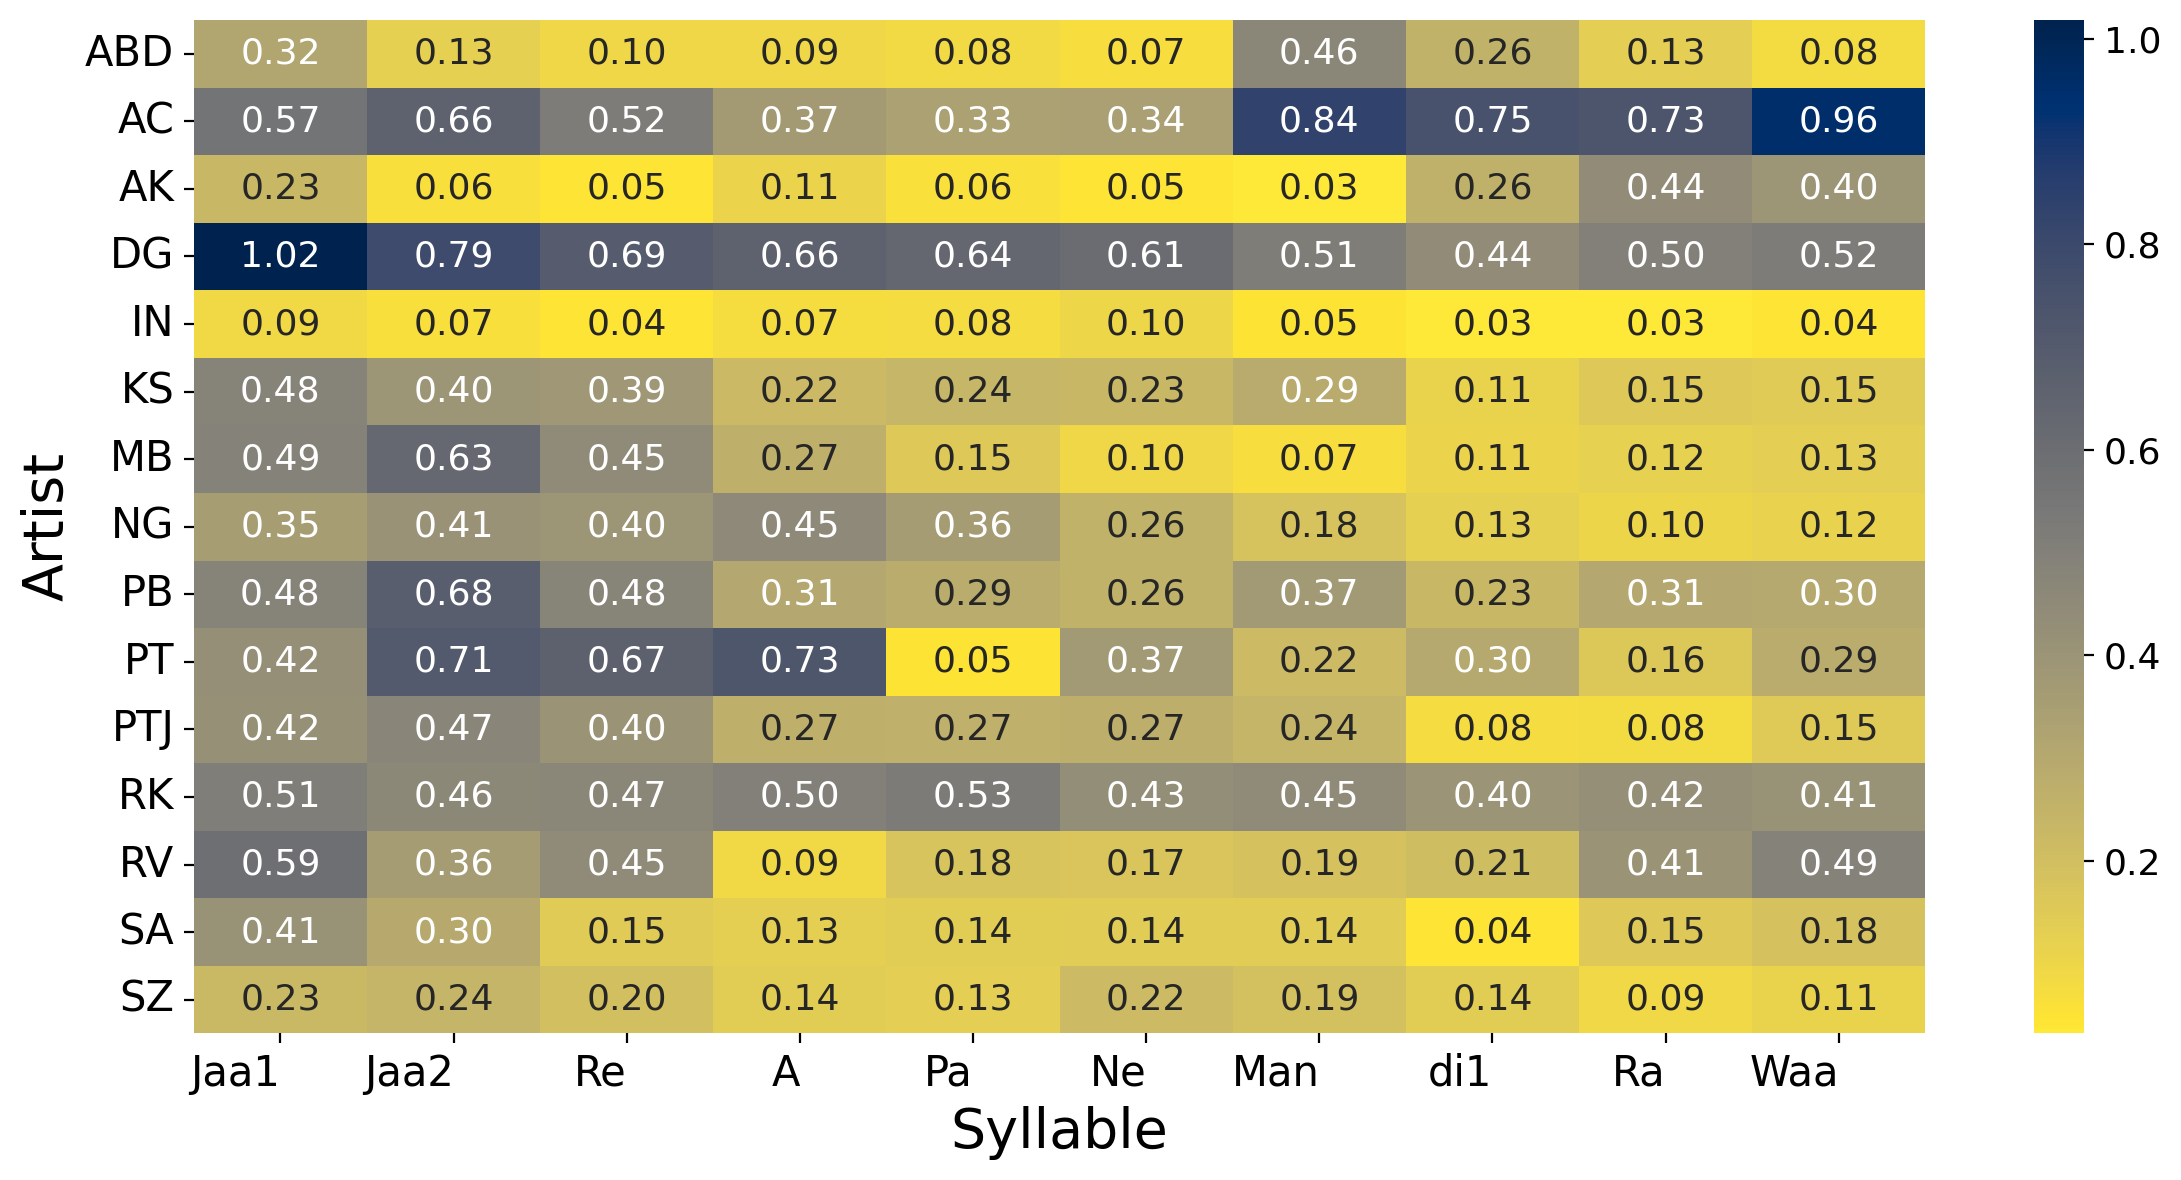

In [41]:

def plot_syllable_heatmap(data_dict):
    syllables = syl_list
    df = pd.DataFrame.from_dict(data_dict, orient='index', columns=[ja_jare_eng_dict[syl] for syl in syllables])

    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(
        df,
        annot=True,
        fmt=".2f",
        cmap="cividis_r",
        annot_kws={"size": 13}  # <- Increase font size of numbers inside heatmap
    )

    # Set axis labels
    plt.xlabel("Syllable", fontsize=20)
    plt.ylabel("Artist", fontsize=20)
    plt.yticks(rotation=0, fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), ha='right', size=15)

    # Increase colorbar tick label font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=13)  # <- Font size for colorbar ticks

    plt.tight_layout()
    plt.show()


plot_syllable_heatmap(syllable_devn_devns)


aggregation box plots

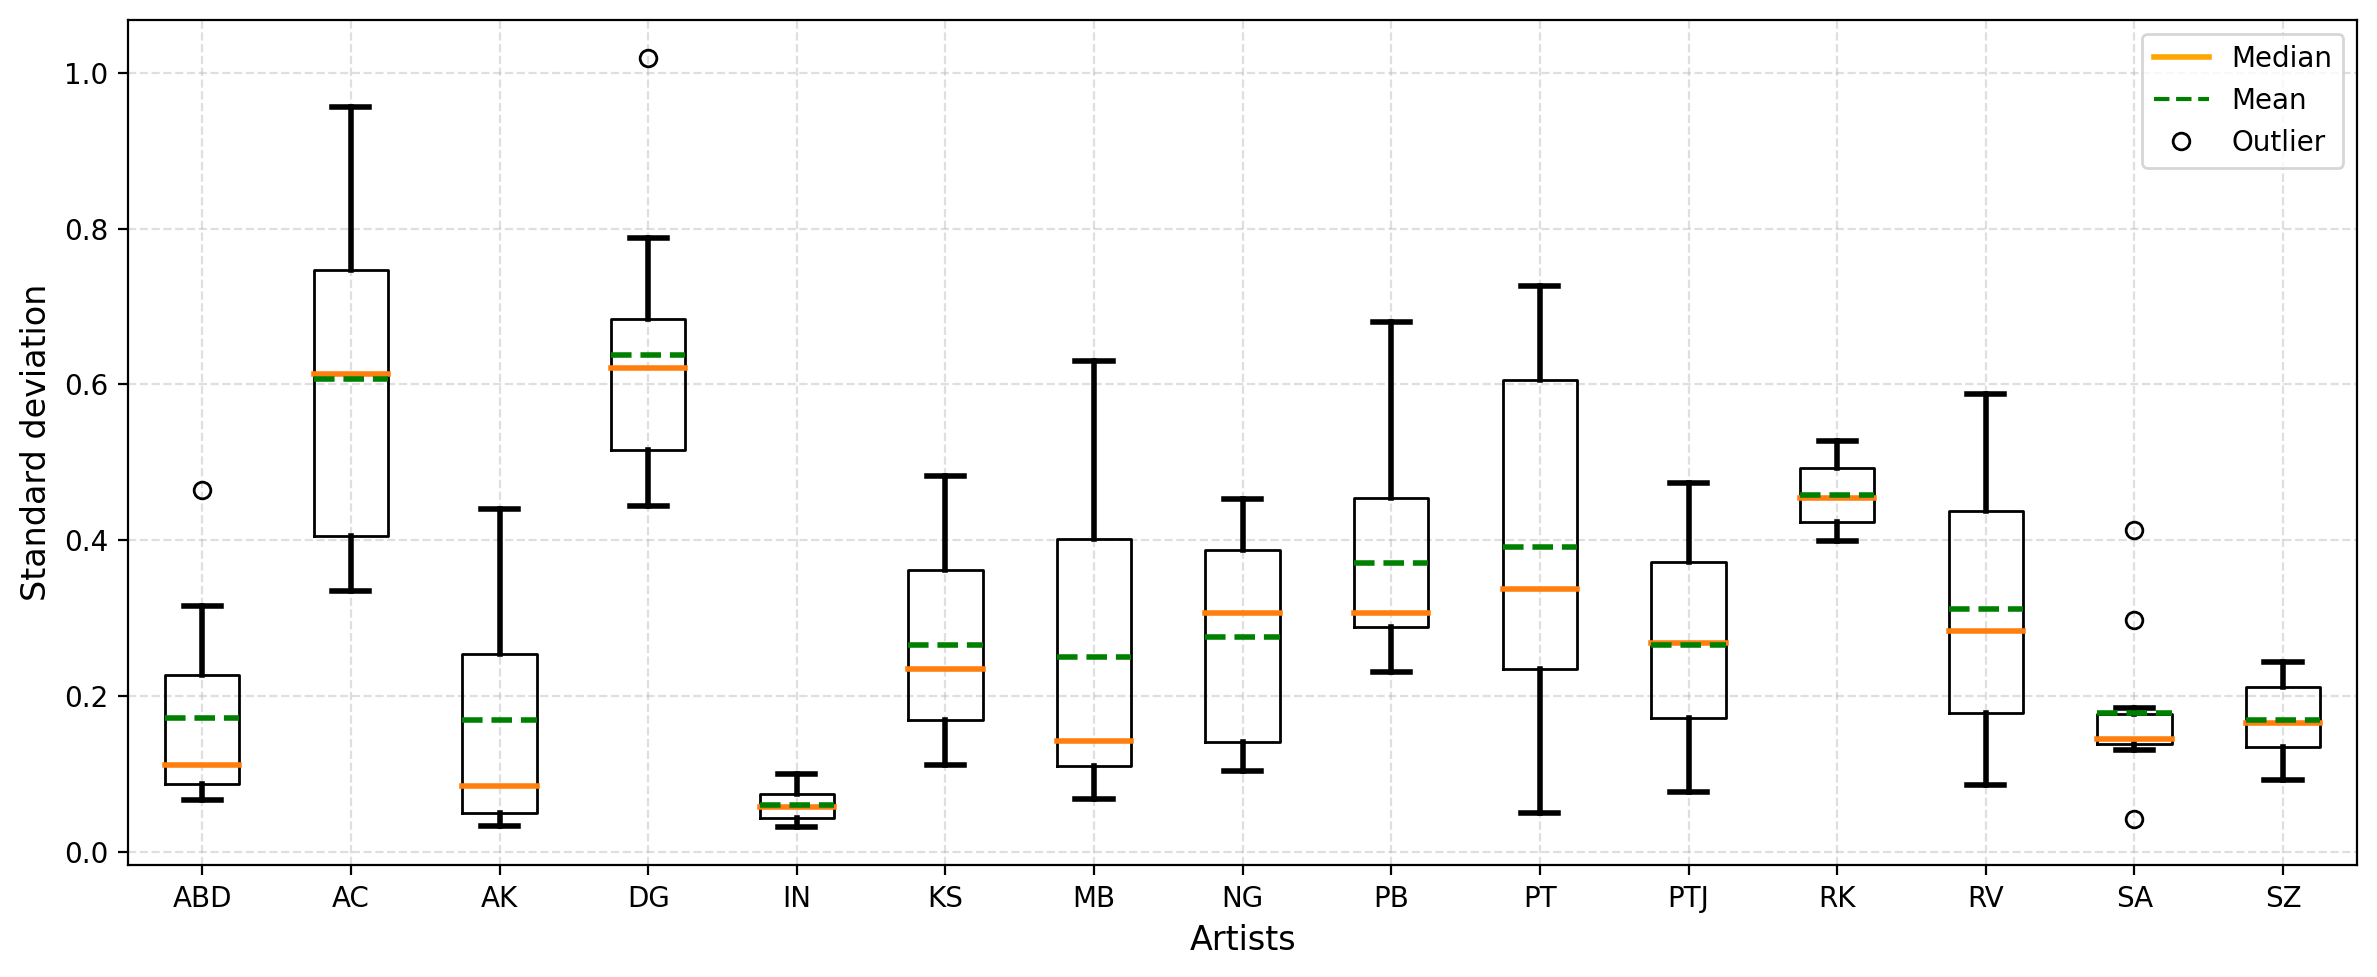

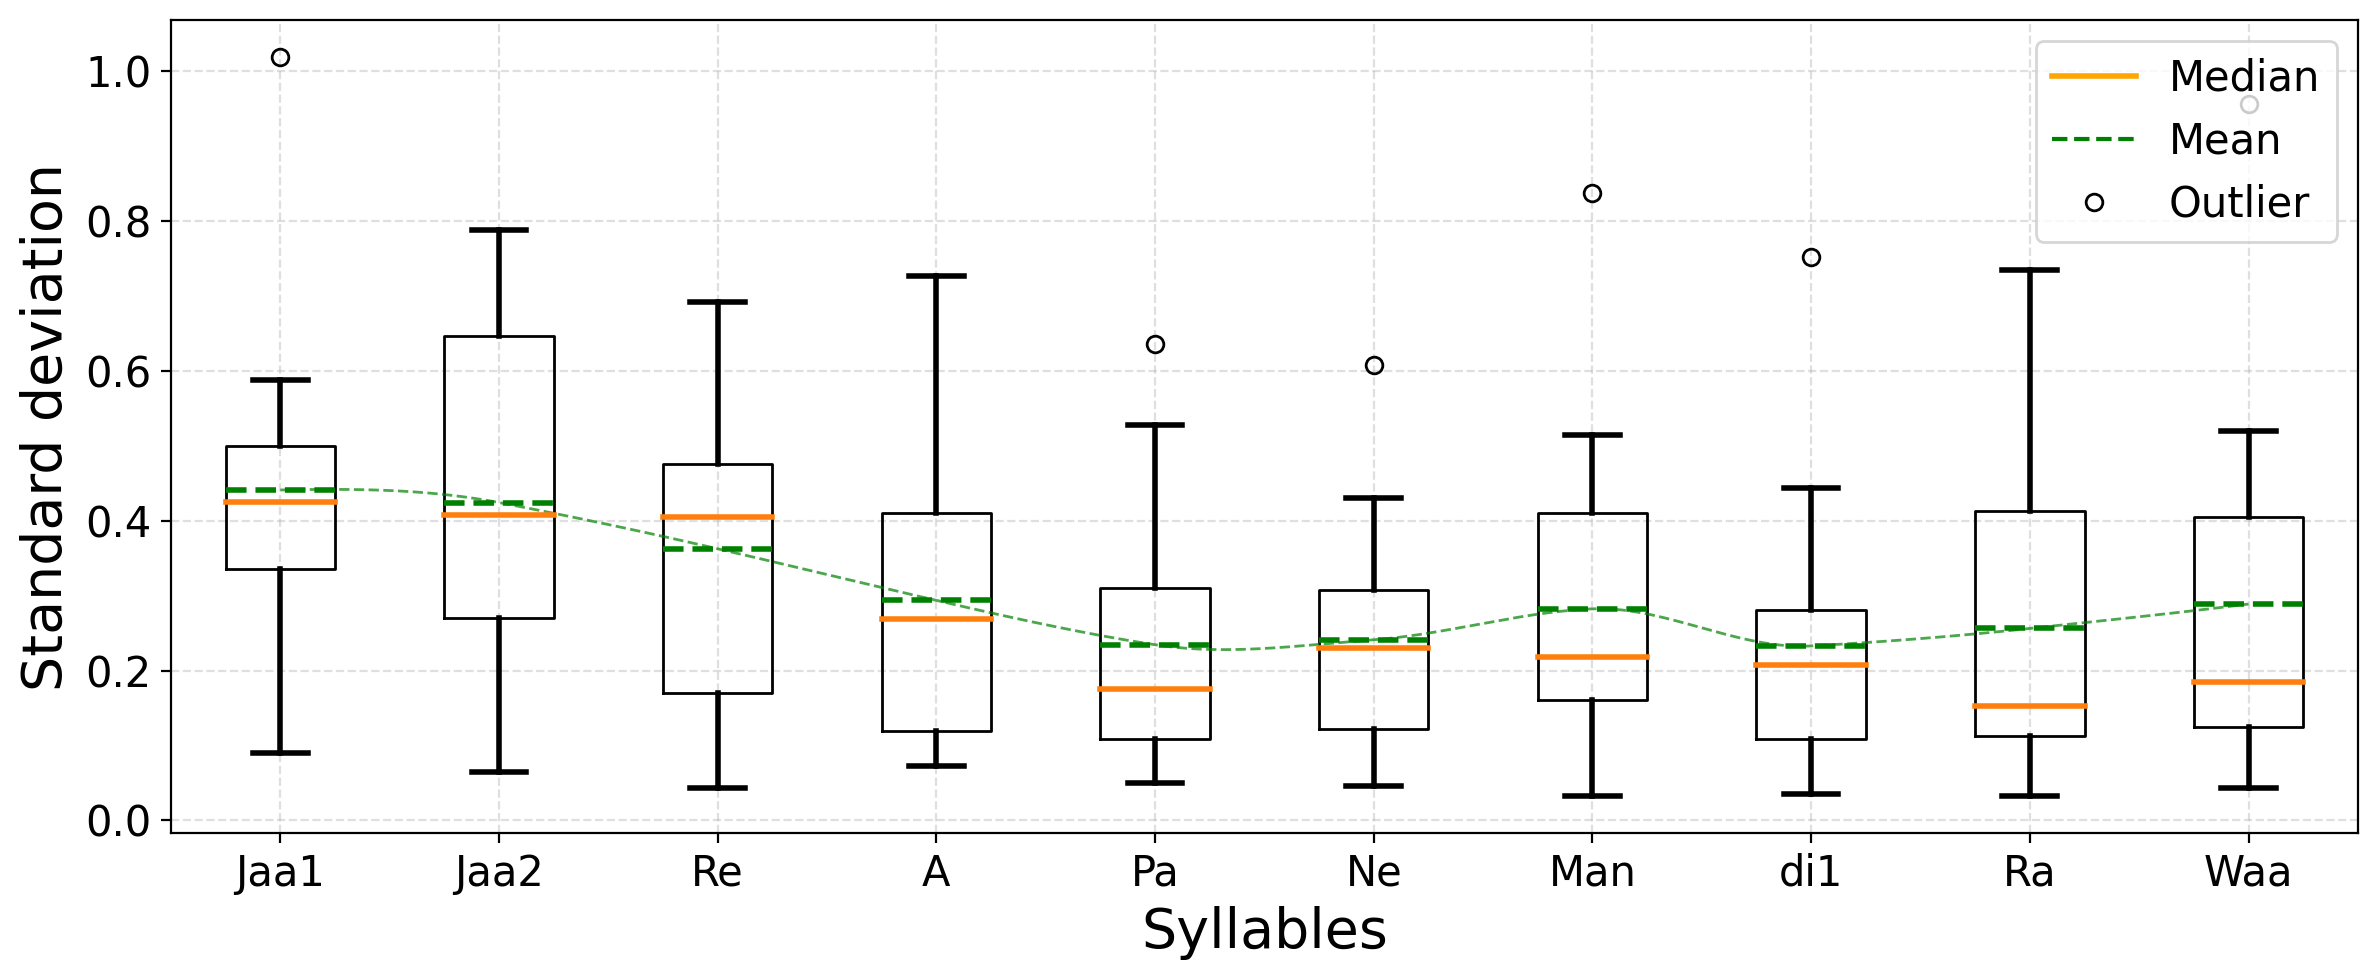

In [43]:
def box_plots(data):

    artist_names = list(data.keys())
    matrix = np.array(list(data.values()))  # Shape: (15, 10)

    # --- Boxplot 1: Across artists (each artist's distribution of 10 syllables) ---
    plt.figure(figsize=(12, 5))
    plt.boxplot(
        matrix.T,
        labels=artist_names,
        showfliers=True,
        meanline=True,
        showmeans=True,
        boxprops=dict(linewidth=1),
        medianprops=dict(linewidth=2),
        whiskerprops=dict(linewidth=2),
        capprops=dict(linewidth=2),
        meanprops=dict(linewidth=2, color='green')  # for mean lines
    )

    # plt.title("Distribution Across Artists")
    plt.xlabel("Artists", fontsize=12)
    plt.ylabel("Standard deviation", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)

        # Custom legend handles
    legend_elements = [
        Line2D([0], [0], color='orange', lw=2, label='Median'),
        Line2D([0], [0], color='green', linestyle='--', label='Mean'),
        Line2D([0], [0], linestyle='none', marker='o', markerfacecolor='none', markeredgecolor='black', label='Outlier', markersize=6)
    ]

    plt.legend(handles=legend_elements, loc='upper right')
    plt.tight_layout()
    plt.show()

    # --- Boxplot 2: Across syllables (distribution per syllable across artists) ---
    plt.figure(figsize=(12, 5))
    syllable_labels = [f"Syl{i+1}" for i in range(matrix.shape[1])]
    plt.boxplot(
        matrix,
        labels=[ja_jare_eng_dict[syl] for syl in syl_list],
        showfliers=True,
        meanline=True,
        showmeans=True,
        boxprops=dict(linewidth=1),
        medianprops=dict(linewidth=2),
        whiskerprops=dict(linewidth=2),
        capprops=dict(linewidth=2),
        meanprops=dict(linewidth=2, color='green')  # for mean lines
    )
    # Compute artist-wise mean across syllables
    mean_vals = np.mean(matrix.T, axis=1)
    x_coords = np.arange(1, len(mean_vals) + 1)

    # Akima interpolation for the means
    akima = Akima1DInterpolator(x_coords, mean_vals)
    x_dense = np.linspace(1, len(mean_vals), 500)
    y_dense = akima(x_dense)
    plt.plot(x_dense, y_dense, linestyle='--', color='green', linewidth=1, label='Akima Mean Curve', alpha = 0.7)
    # plt.title("Distribution Across Syllables")
    plt.xlabel("Syllables", fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel("Standard deviation", fontsize=20)
    plt.grid(True, linestyle='--', alpha=0.4)

    plt.legend(handles=legend_elements, loc='upper right', fontsize=15)
    plt.tight_layout()
    plt.show()


box_plots(syllable_devn_devns)

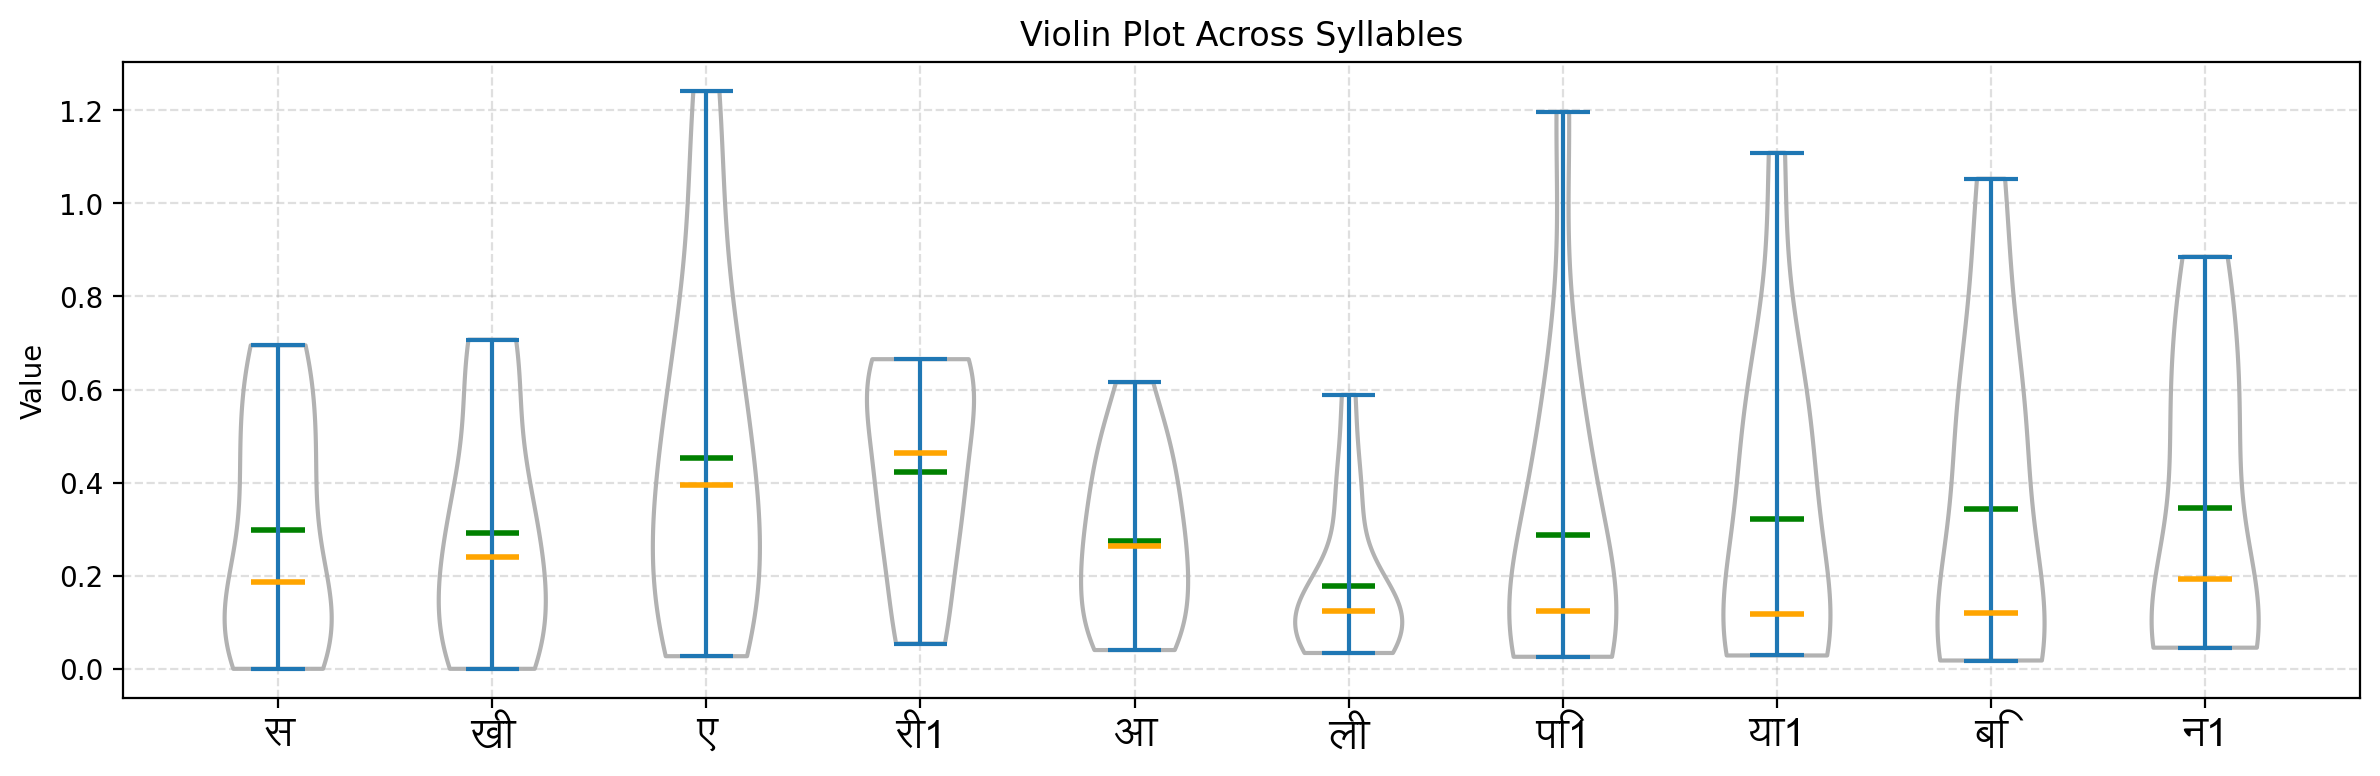

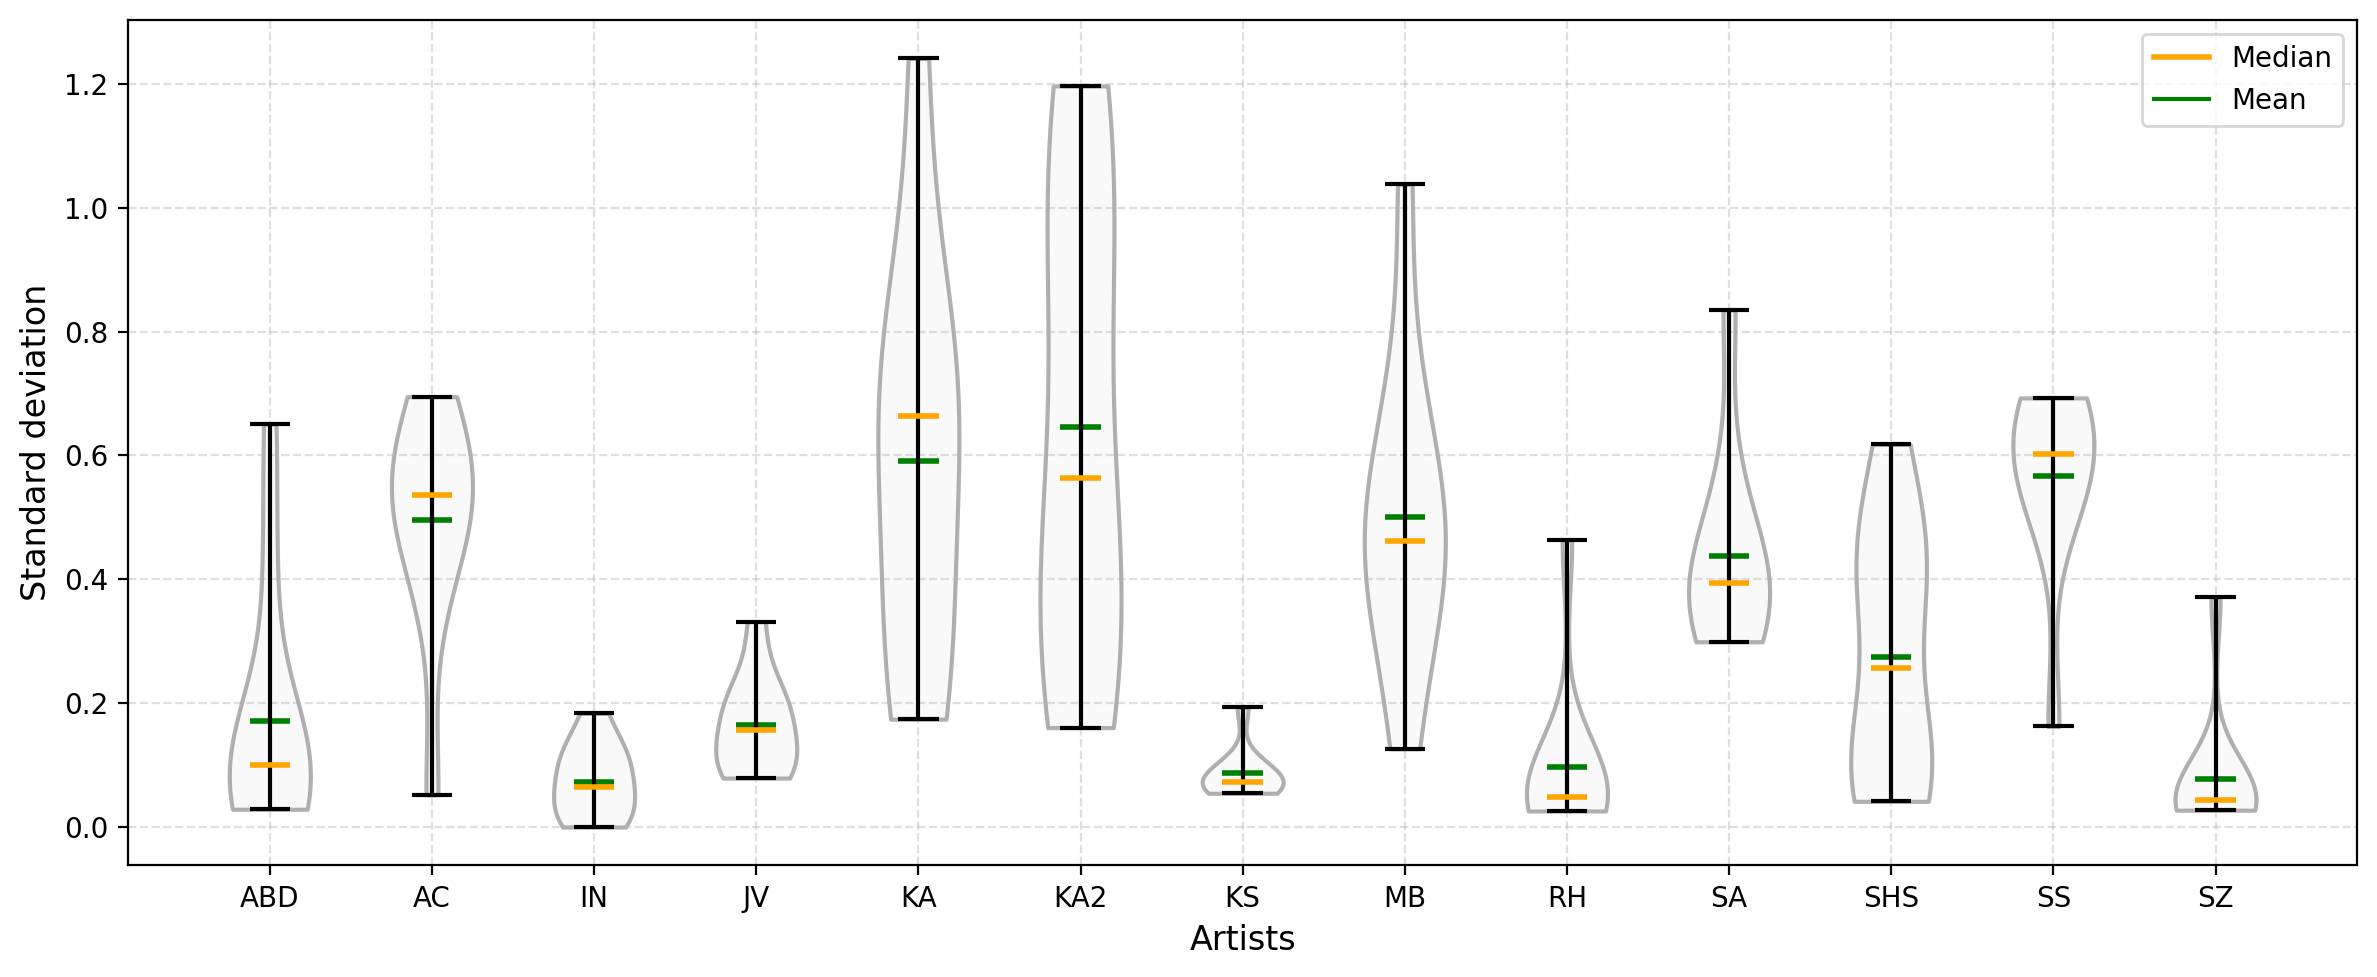

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def violin_plots(data_dict):
    artist_names = list(data_dict.keys())
    matrix = np.array(list(data_dict.values()))  # shape: (num_artists, 10)

    # --- Violin Plot 1: Across syllables ---
    plt.figure(figsize=(12, 4))
    syllable_labels = [f"Syl{i+1}" for i in range(matrix.shape[1])]
    
    vp = plt.violinplot(matrix, showmeans=True, showextrema=True, showmedians=True)

    # Make the violins hollow
    for body in vp['bodies']:
        body.set_facecolor('none')         # No fill
        body.set_edgecolor('black')        # Black outline
        body.set_linewidth(1.5)

    # Style mean, median, extrema
    vp['cmeans'].set_color('green')
    vp['cmeans'].set_linewidth(2)
    vp['cmedians'].set_color('orange')
    vp['cmedians'].set_linewidth(2)
    vp['cbars'].set_linewidth(1.5)         # extrema vertical lines

    plt.xticks(ticks=np.arange(1, len(syllable_labels)+1), labels=syl_list)
    plt.title("Violin Plot Across Syllables")
    plt.ylabel("Value")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

    # --- Violin Plot 2: Across artists ---
    plt.figure(figsize=(12, 5))
    vp2 = plt.violinplot(matrix.T, showmeans=True, showextrema=True, showmedians=True)

    for body in vp2['bodies']:
        body.set_facecolor('#eeeeee')
        body.set_edgecolor('black')
        body.set_linewidth(1.5)

    vp2['cmeans'].set_color('green')
    vp2['cmeans'].set_linewidth(2)
    vp2['cmedians'].set_color('orange')
    vp2['cmedians'].set_linewidth(2)
    vp2['cbars'].set_linewidth(1.5)
    vp2['cbars'].set_color('black')
    vp2['cmaxes'].set_color('black')
    vp2['cmins'].set_color('black')


    plt.xticks(ticks=np.arange(1, len(artist_names)+1), labels=artist_names)
    # plt.title("Violin Plot Across Artists")
    plt.ylabel("Standard deviation", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)
            # Custom legend handles
    legend_elements = [
        Line2D([0], [0], color='orange', lw=2, label='Median'),
        Line2D([0], [0], color='green', linestyle='-', label='Mean')
    ]

    plt.legend(handles=legend_elements, loc='upper right')
    plt.xlabel("Artists", fontsize=12)
    plt.tight_layout()
    plt.show()

violin_plots(syllable_devn_devns)

temporal expression for each syllable, and for each artist, (aggregation)

In [31]:
import pandas as pd

def summarize_std_deviation(data_dict):
    """
    Aggregates standard deviation data:
    1. Row-wise mean (per artist)
    2. Column-wise mean (per syllable)

    Returns:
        summary_df (pd.DataFrame): Summary table with both row and column means.
    """
    # Convert dict to DataFrame
    syllables = ["जा1", "जा2", "रे", "अ", "प", "ने", "मं", "दि1", "र", "वा"]
    df = pd.DataFrame.from_dict(data_dict, orient='index', columns=syllables)

    # Row-wise mean (mean std. dev per artist)
    artist_mean = df.mean(axis=1).rename("Mean_StdDev_per_Artist")

    # Column-wise mean (mean std. dev per syllable)
    syllable_mean = df.mean(axis=0).rename("Mean_StdDev_per_Syllable")

    artist_df = pd.Series(artist_mean).round(3).to_frame().T

    # Combine into a summary table
    # artist_df = artist_mean.to_frame()
    syllable_df = pd.Series(syllable_mean).round(3).to_frame().T  # single-row DataFrame

    return artist_df, syllable_df

artist_temporal_devn, syllable_temporal_devn = summarize_std_deviation(syllable_devn_devns)

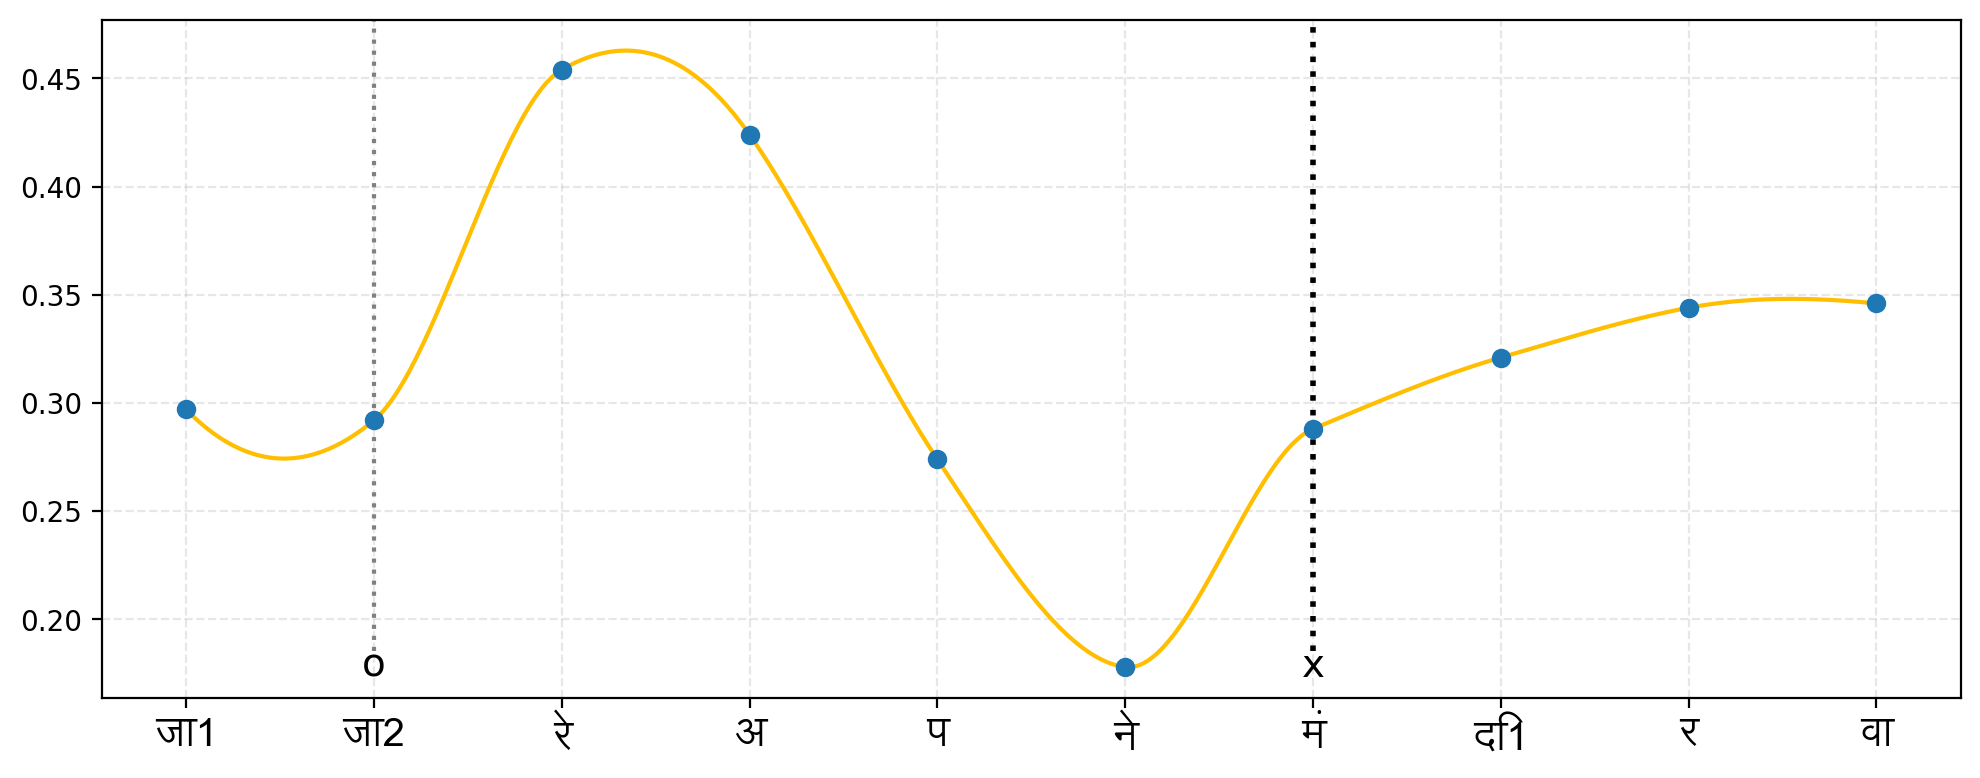

In [ ]:

# Extract syllables and values
syllables = list(syllable_temporal_devn.columns)
values = syllable_temporal_devn.iloc[0].values
x = np.arange(len(syllables))

# Interpolation
akima = Akima1DInterpolator(x, values)
x_dense = np.linspace(0, len(syllables)-1, 500)
y_dense = akima(x_dense)

# Plot setup
plt.figure(figsize=(10, 4))
plt.plot(x_dense, y_dense, color='#FFBF00')
plt.scatter(x, values, color='#1f77b4', zorder=3)

# Limits
y_min, y_max = plt.ylim()
marker_y = y_min + 0.02 * (y_max - y_min)  # Small offset from bottom

# Vertical line and 'o' at जा2
idx_ja2 = syllables.index('जा2')
plt.axvline(x=idx_ja2, ymin=0.07, ymax=1, color='gray', linestyle='dotted')  # end low
plt.text(idx_ja2, marker_y, 'o', fontsize=14, ha='center', va='bottom')

# Vertical bold line and 'x' at मं
idx_man = syllables.index('मं')
plt.axvline(x=idx_man,ymin=0.07, ymax=1, color='black', linestyle='dotted', linewidth=2)
plt.text(idx_man, marker_y, 'x', fontsize=14, ha='center', va='bottom')

# Axis labels
plt.xticks(ticks=x, labels=syllables, fontsize=20)
# plt.ylabel("Mean_StdDev_per_Syllable", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

